# installing required libraries

In [1]:
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# please restart runtime new file work after restart runtime

---



In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import json
import glob
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path = ''



---


# visualization of sift

---



------ image--------


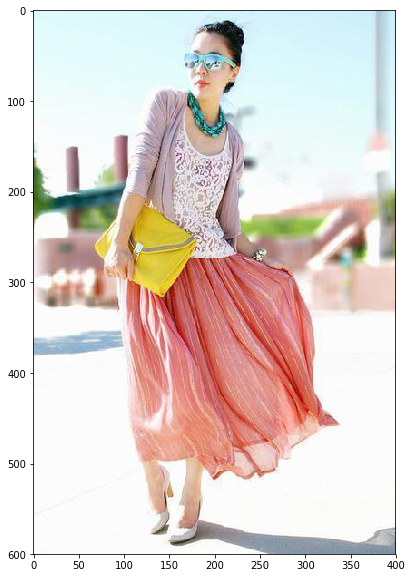

------crop image-----


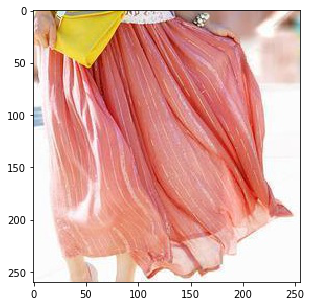

In [4]:
img = plt.imread(data_path+"images/d469bcc8-d501-5b75-81b0-00eabb7a2238.jpg")
img2 = img.copy()
template = plt.imread(data_path+'crops/0db89e0b-5860-5025-a314-4ebc6159ca2b.jpg')
_,w, h = template.shape[::-1]
print('------ image--------')
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()
print('------crop image-----')
plt.figure(figsize=(5,5))
plt.imshow(template)
plt.show()

# compute sift features and machting

In [5]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img,None)
kp2, des2 = sift.detectAndCompute(template,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
good = []
c = 0
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])
        c+=1

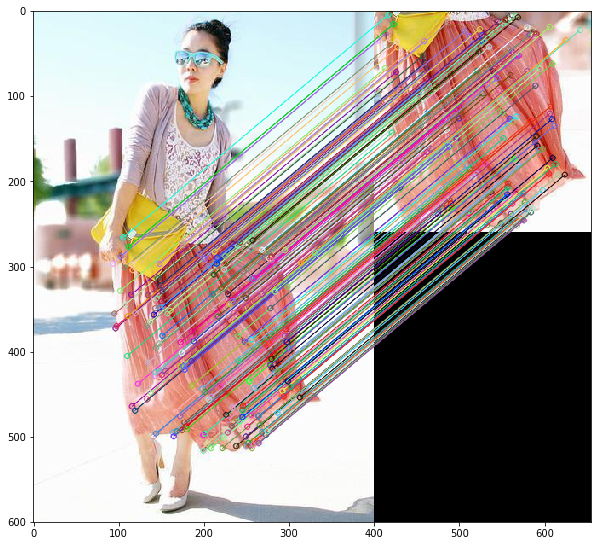

In [6]:
img3 = cv2.drawMatchesKnn(img,kp1,template,kp2,good,None,flags=2)
plt.figure(figsize=(10,10))
plt.imshow(img3)
plt.show()

## match sift features and create dict for save in json file

In [7]:
img2 = img.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
template2 = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

res = cv2.matchTemplate(gray, template2, cv2.TM_SQDIFF_NORMED)

min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)


min_thresh = (min_val)*1.1
match_locations = np.where(res<=min_thresh)


for (x, y) in zip(match_locations[1], match_locations[0]):
    cv2.rectangle(img2, (x, y), (x+w, y+h), [0,0,255], 2)

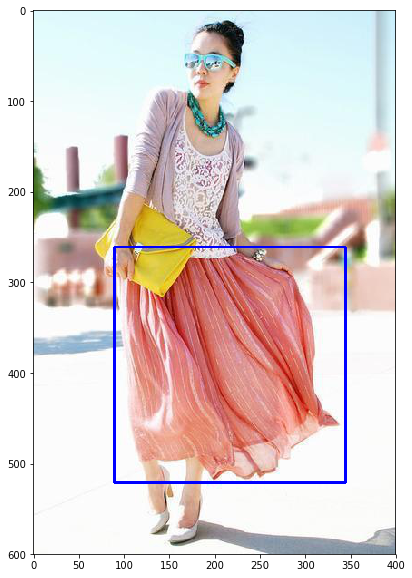

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(img2)
plt.show()



---



---



---



## sift feature detection and compute on data

In [9]:
def match_features(des1, des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)
    match = 0
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            match += 1
    return match


def calculate_shift_features(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des


def get_templet(img2, template):
    img = img2.copy()
    _, w, h = template.shape[::-1]
    try:
        res = cv2.matchTemplate(img, template, cv2.TM_SQDIFF_NORMED)
    except:
        print('template matching failed template size is greater than image size')
        return
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    return [top_left[0],top_left[1], bottom_right[0],bottom_right[1]]

In [10]:
img_data = dict()
for img_file in glob.glob(data_path + 'images/*.jpg'):
    img = plt.imread(img_file)
    des = calculate_shift_features(img)
    img_data[img_file] = des

In [11]:
crop_img_data = dict()
for img_file in glob.glob(data_path + 'crops/*.jpg'):
    img = plt.imread(img_file)
    des = calculate_shift_features(img)
    crop_img_data[img_file] = des

In [12]:
def get_top_4(match_num):
    index = [0, 0, 0, 0]
    for k in range(0, 4):
        mx = -1
        for i in range(len(match_num)):
            if i in index:
                continue
            if match_num[i] > mx:
                mx = match_num[i]
                index[k] = i
    return index

In [13]:
data = dict()
temp = []
c = 0
image_name = list(img_data.keys())
crop_name = list(crop_img_data.keys())
for image in image_name:
    if c%10==0:
      print('image processed ',c)
    c+=1
    match_num = []
    for crop in crop_name:
        try:
            match = match_features(img_data[image], crop_img_data[crop])
            match_num.append(match)
        except:
            match_num.append(0)
    data[image] = get_top_4(match_num)

image processed  0
image processed  10
image processed  20
image processed  30
image processed  40
image processed  50
image processed  60


In [14]:
del img_data
del crop_img_data

# template matching

In [15]:
json_dict = dict()
for image in image_name:
    img = plt.imread(image)
    img_name = image.split('\\')[-1]
    indx = data[image]
    temp =[]
    for i in indx:
        template = plt.imread(crop_name[i])
        crop_filename = crop_name[i].split('\\')[-1]
        temp.append([crop_filename[:-4],get_templet(img,template)])    
    json_dict[img_name[:-4]] = temp

template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size
template matching failed template size is greater than image size


## write final json file

In [16]:
with open('result.json','w') as file:
    json.dump(json_dict,file)  #final json file save 'result.json'